In [44]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import random
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import networkx as nx

In [45]:
P = 20
L = 20
d_max = 10
BS = [P/2, L/2]

N = 10
m = 15
kc = 25
kd = 250
kt = kd + N
beta = 0.8
data_rate = 500 # bps
t_transmission =  ((kd * 8)/data_rate) + ((kc * 8)/data_rate) + (((kc + N) * 8)/data_rate)
initial_energy = 1
E_elec = 50 * 1e-9
E_amp =  10 * 1e-5
E_fs = 10*1e-12
E_mp = 0.0013*1e-12
p = 0.05
DECKS_threshold = 3

In [46]:
def ratio_delay(distance):
    v = 3 * 1e8
    t = distance/v
    a = t/t_transmission
    # print(f"Ratio delay : {a:.2f} | T_tranmission : {t_transmission:.2f} | T_uw : {t_uw:.2f}")
    return a

def throughput(a):
    numerator = kc * np.exp(-a * kc)
    denominator = kc * (1 + 2 * a) + np.exp(-a * kc)
    rho = numerator / denominator
    # print(f"Throughput : {rho:.2f} | numerator : {numerator:.2f} | denominator : {denominator:.2f}")
    return rho


class Node:
    def __init__(self, x, y, id):
        self.x = x
        self.y = y
        self.energy = initial_energy
        self.nϵG = False
        self.alive = True
        self.CH = False
        self.which_cluster = 0
        self.eligible_round = 0
        self.cluster_class = 0
        self.id = id

    def distance(self, other_node):
        return np.sqrt((self.x - other_node.x)**2 + (self.y - other_node.y)**2)

    def reset(self):
        self.CH = False
        self.which_cluster = 0

    def advertisement(self, count_cluster, eligible_round):
        self.CH = True
        self.nϵG = False
        self.eligible_round = eligible_round
        self.which_cluster = count_cluster

    def energySelection(self, d_CH_BS, p):
        # If node selected as a CH
        a = ratio_delay(d_CH_BS)
        rho = throughput(a)
        first_term = (kc / rho) * (E_elec + E_amp * (d_CH_BS**2))
        second_term = (p * (N - 1) / rho) * (beta * E_elec * kc)
        third_term = E_elec * kt
        E_Selection = first_term + second_term + third_term
        return E_Selection

    def energyIdle(self):
        return beta * E_elec * kc

    def energyAdvertisement(self):
        # Broadcasting to all nodes in the range of d_max, occurs only for CH
        return kc * (E_elec + E_amp * (d_max**2))

    def energyJoin(self, p):
        # Node receive the broadcasting message and decide whether want to join as a associated node for CH i-th
        return p * N * kc * E_elec

    def energy_contention_TDMA_CH(self, Nc):
        return kc * Nc * E_elec + kt * (E_elec + E_amp * (d_max**2))

    def energy_contention_TDMA_Node(self, d_CH_Node):
        a = ratio_delay(d_CH_Node)
        rho = throughput(a)
        energy = (kc / rho) * (E_elec + E_amp * (d_CH_Node**2)) + ((N-1)/ rho) * kc * beta * E_elec + kt * E_elec
        return energy

    def energyFrame_CH(self, Nc, d_CH_BS):
        return m * Nc * kd * E_elec * beta * kd * E_elec + kd * (E_elec +  E_amp * (d_CH_BS**2))

    def energyFrame_Node(self, d_CH_Node):
        return m * kd * E_elec * (E_elec + E_elec +  E_amp * (d_CH_Node**2))


In [47]:
def createNetworks(N, P, L):
    areaTotal = P * L

    #Point process parameters
    lambda0 = N/(P * L)

    #Simulate a Poisson point process
    numbPoints = np.random.poisson(lambda0 * areaTotal)
    xx = P * np.random.uniform(0,1,numbPoints)
    yy = L * np.random.uniform(0,1,numbPoints)

    nodes = []
    nodes.append(Node(P//2, L//2, 0))

    for i in range(len(xx)):
        nodes.append(
            Node(xx[i], yy[i], i + 1)
        )

    return nodes

In [48]:
class multiHop(object):
    def __init__(self,graph):
        self.graph = graph
        self.adjacent_mat = nx.adjacency_matrix(graph).todense()
        self.num_nodes = len(self.adjacent_mat)
        self.adjacent_mat = nx.adjacency_matrix(graph, nodelist=range(self.num_nodes)).toarray()#:D
        # print(f"\n Adjacent Matrix \n{self.adjacent_mat}\n")

    def q_learning(self,start_state=0, aim_state = 10, num_epoch=200, gamma=0.8, epsilon=0.05, alpha=0.1):

        len_of_paths = []
        rewards = self.rewardMapping(start_state, aim_state)
        # print(f"\n Reward \n{rewards}\n")


        q_table = np.zeros((self.num_nodes, self.num_nodes))  # num_states * num_actions
        td = []

        for episode in range(1, num_epoch + 1):
            #print(f"========================================================================== Episode : {episode} =========================================================================")
            current_state = start_state
            path = [current_state]
            len_of_path = 0
            while True:
                next_state = self.epsilon_greedy(current_state, q_table, start_state, epsilon=epsilon)
                s_next_next = self.epsilon_greedy(next_state, q_table, start_state, epsilon=epsilon)  # epsilon<0, greedy policy
                # update q_table
                reward = rewards[current_state][next_state]
                delta = reward + gamma * q_table[next_state, s_next_next] - q_table[current_state, next_state]

                q_table[current_state, next_state] = q_table[current_state, next_state] + alpha * delta
                # update current state
                current_state = next_state
                len_of_path += -reward
                path.append(current_state)


                td.append(delta)
                if current_state == aim_state:
                    break
            len_of_paths.append(len_of_path)

        return path, td

    def epsilon_greedy(self,s_curr, q, start_state, epsilon):
        potential_next_states = np.where(np.array(self.adjacent_mat[s_curr]) <= d_max)[0]
        potential_next_states = potential_next_states[potential_next_states != start_state]
        if random.random() > epsilon:
            q_of_next_states = q[s_curr][potential_next_states]
            s_next = potential_next_states[np.argmax(q_of_next_states)]
        else:
            s_next = random.choice(potential_next_states)
        return s_next

    def rewardMapping(self, start_state, aim_state):
        r = self.adjacent_mat.copy()
        r[:, aim_state] = 1000  # Reward for reaching aim_state
        r[aim_state, :] = 1000  # Reward for starting from aim_state
        for i in range(len(r)):
            for j in range(len(r)):
                if i == j:
                    r[i][j] = -99999  # Penalty for remaining in the same state
                if r[i][j] > d_max:
                    r[i][j] = -1000  # Strong penalty for distances exceeding d_max
        return r


class networkEnvironment:
    def __init__(self, nodes, mode, showInfo, showPlotIteration):
        self.nodes = nodes
        self.mode = mode
        self.alive_data = []
        self.energy_data = []
        self.node_failure = []
        self.centroids = np.array([[P//2, L//2]])
        self.showInfo = showInfo
        self.showPlotIteration = showPlotIteration
        self.multihop_path = []
    
    def showResult(self, hop):
        fig, ax = plt.subplots(1, 3, figsize=(20,5))
        rounds = np.array([i for i in range(0, len(self.alive_data))])
        self.alive_data = np.array(self.alive_data)
        self.energy_data = np.array(self.energy_data)
        self.node_failure = np.array(self.node_failure)

        ax[0].plot(rounds, self.alive_data, color='k')
        ax[0].scatter(rounds[::hop], self.alive_data[::hop], marker='o', edgecolor='k', color='r')
        ax[0].set_ylabel("Node Alive")
        ax[0].set_xlabel("Round")

        ax[1].plot(rounds, self.energy_data, color='k')
        ax[1].scatter(rounds[::hop], self.energy_data[::hop], marker='o', edgecolor='k', color='r')
        ax[1].set_ylabel("Energy Consumed")
        ax[1].set_xlabel("Round")

        ax[2].plot(rounds, self.node_failure, color='k')
        ax[2].scatter(rounds[::hop], self.node_failure[::hop], marker='o', edgecolor='k', color='r')
        ax[2].set_ylabel("Node Failure")
        ax[2].set_xlabel("Round")

        ax[0].yaxis.set_major_locator(MultipleLocator(np.abs(np.max(self.alive_data))/20))
        ax[0].yaxis.set_major_formatter('{x:.2f}')
        ax[0].yaxis.set_minor_locator(MultipleLocator(np.abs(np.max(self.alive_data))/30))
        ax[0].xaxis.set_major_locator(MultipleLocator(np.max(rounds)/5))
        ax[0].xaxis.set_major_formatter('{x:.2f}')
        ax[0].xaxis.set_minor_locator(MultipleLocator(np.max(rounds)/10))
        
        ax[1].yaxis.set_major_locator(MultipleLocator(np.abs(np.max(self.energy_data))/20))
        ax[1].yaxis.set_major_formatter('{x:.2f}')
        ax[1].yaxis.set_minor_locator(MultipleLocator(np.abs(np.max(self.energy_data))/30))
        ax[1].xaxis.set_major_locator(MultipleLocator(np.max(rounds)/5))
        ax[1].xaxis.set_major_formatter('{x:.2f}')
        ax[1].xaxis.set_minor_locator(MultipleLocator(np.max(rounds)/10))

        # ax[2].yaxis.set_major_locator(MultipleLocator(np.abs(np.max(self.node_failure))/10))
        # ax[2].yaxis.set_major_formatter('{x:.2f}')
        # ax[2].yaxis.set_minor_locator(MultipleLocator(np.abs(np.max(self.node_failure))/20))
        # ax[2].xaxis.set_major_locator(MultipleLocator(np.max(rounds)/5))
        # ax[2].xaxis.set_major_formatter('{x:.2f}')
        # ax[2].xaxis.set_minor_locator(MultipleLocator(np.max(rounds)/10))


    def showNetwork(self, simulation_round):
        fig, ax = plt.subplots()
        normal_nodes = {'x':[], 'y':[]}
        orphan_nodes = {'x':[], 'y':[]}
        CH_nodes = {'x':[], 'y':[]}
        BS_node = {'x':[], 'y':[]}
        dead_nodes = {'x':[], 'y':[]}
        energy = 0
        node_alive = 0
        count_CH = 0

        for node in self.nodes:
            normal_node_status = ((node.id != 0) and (node.CH == False) and (node.which_cluster != 0) and (node.energy > 0))
            orphan_node_status = ((node.id != 0) and (node.CH == False) and (node.which_cluster == 0) and (node.energy > 0))
            CH_node_status = ((node.id != 0) and (node.CH == True) and (node.alive) and (node.energy > 0))
            dead_node_status = ((node.id != 0) and (node.energy < 0) and (node.alive != True))
            if normal_node_status:
                normal_nodes['x'].append(node.x)
                normal_nodes['y'].append(node.y)
            if orphan_node_status:
                orphan_nodes['x'].append(node.x)
                orphan_nodes['y'].append(node.y)
            if CH_node_status:
                CH_nodes['x'].append(node.x)
                CH_nodes['y'].append(node.y)
                count_CH += 1
            if node.id == 0:
                BS_node['x'].append(node.x)
                BS_node['y'].append(node.y)
            if dead_node_status:
                dead_nodes['x'].append(node.x)
                dead_nodes['y'].append(node.y)
            if node.alive:
                energy += node.energy
                node_alive += 1

        energy = np.round(energy, 2)
        ax.scatter(normal_nodes['x'], normal_nodes['y']         , marker="o",color='purple' , edgecolors='k', label = "Node")
        ax.scatter(orphan_nodes['x'], orphan_nodes['y']         , marker="o",color='c'      , edgecolors='k', label = "Orphan Node")
        ax.scatter(CH_nodes['x'], CH_nodes['y']                 , marker="o",color="g"      , edgecolors='k', label = "Cluster Head")
        ax.scatter(dead_nodes['x'], dead_nodes['y']             , marker="x",color='r'      , label="Dead Node")
        ax.scatter(self.centroids[:,0], self.centroids[:,1]     , marker="o",color="y"      , edgecolors='k', label="Centroid")
        ax.scatter(BS_node['x'], BS_node['y']                   , marker="s",color="b"      , edgecolors='k', label="Base station", s=50)

        font = {
                'color':  'black',
                'weight': 'bold'
                }

        print(f"Paths : {self.multihop_path}")
        if self.mode == "Q-Learning":
            for index_path in range(len(self.multihop_path)-1):
                print(f"{index_path} | Path : {len(self.multihop_path)} | Node : {len(self.nodes)}")
                start_x = self.nodes[self.multihop_path[index_path]].x
                start_y = self.nodes[self.multihop_path[index_path]].y
                end_x = self.nodes[self.multihop_path[index_path+1]].x
                end_y = self.nodes[self.multihop_path[index_path+1]].y

                # Compute the direction (vector) from start to end
                dx = end_x - start_x
                dy = end_y - start_y
                ax.quiver(start_x, start_y, dx, dy, angles='xy', scale_units='xy', scale=1, width=0.005)

        ax.set_title(f'Round : {simulation_round} | E : {energy} | CH : {count_CH}', fontdict=font)
        ax.set_xlabel('Length (m)')
        ax.set_ylabel('Width (m)')
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
              fancybox=True, shadow=True, ncol=5, markerscale=1, fontsize=10)
        plt.tight_layout()
        plt.show()

    def multiHopRouting(self, node):
        # Creatubg ab Adjacency Matrix for Q-Learning
        status = (
                (node.energy > 0) and 
                (node.alive == True)
            )
        G = nx.Graph()

        for nodeA in self.nodes:
            for nodeB in self.nodes:
                if ((nodeA.id != nodeB.id) and (status)) :
                    distances = self.euclidean_distance(np.array([nodeA.x, nodeA.y]), np.array([nodeB.x, nodeB.y]))
                    G.add_edge(nodeA.id, nodeB.id, weight=distances)
        print(G)
        Q_learning = multiHop(G)
        paths, _ = Q_learning.q_learning(start_state=node.id, aim_state = 0, num_epoch=10000, gamma=0.01, epsilon=0.01, alpha=0.1)
        print(f"Node : {node.id} => Paths : {paths}")
        return paths
    
    def euclidean_distance(self, nodeA, nodeB):
        return np.sqrt(np.sum((nodeA - nodeB)**2))
        
    def Nc(self, which_cluster):
        count = 0
        for node in self.nodes:
            if node.which_cluster == which_cluster:
                count += 1
        return count
    
    def LEACH(self, round_number):
        for node in self.nodes:
            d_CH_BS = self.euclidean_distance(np.array([node.x, node.y]), np.array(BS))
            status = (
                (node.energy > 0) and 
                (node.alive == True) and 
                (node.eligible_round == 0) and
                (d_CH_BS < d_max)
            )
            threshold = random.uniform(0, 1) <= p/(1-p * (round_number % (1/p)))
            if ((status) and (threshold)):
                node.CH = True
                node.which_cluster = node.id
                node.eligible_round = 1/p
                
    
    def CH_selection(self, round_number):
        for node in self.nodes:
            node.reset()
            
       
        self.LEACH(round_number)
        
        CHs = [node for node in self.nodes if node.CH]
        for node in self.nodes:
            status = ((node.energy > 0) and (node.alive == True) and (node.id != 0) and (node.CH != True))
            if len(CHs):
                distances = [[], []]
                if status:
                    for CH in CHs:
                        distances[0].append(self.euclidean_distance(np.array([node.x, node.y]), np.array([CH.x, CH.y])))
                        distances[1].append(CH.which_cluster)
                    if distances[0][np.argmin(distances[0])] > d_max:
                        node.which_cluster = 0
                    else:
                        node.which_cluster = distances[1][np.argmin(distances[0])]
            if len(CHs) <= 0:
                # Jika tidak ada yang terpilih sebagai CH, maka node akan diam
                if node.id != 0:
                    node.which_cluster = 0

        if round_number % self.showPlotIteration == 0:
            self.showNetwork(round_number)
            
    def SetupPhase(self, simulation_round):
        # CH Selection and Advertisement Energy Dissipation and Creating TDMA Schedule
        # Node Join Energy Dissipation and join TDMA Schedule
        self.CH_selection(simulation_round)
        CHs = [node for node in self.nodes if node.CH]
        for node in self.nodes:
            status = (
                (node.energy > 0) and 
                (node.alive == True) and 
                (node.id != 0) and 
                (node.which_cluster != 0)
            )
            if status:
                if node.CH:
                    Nc = self.Nc(node.which_cluster)
                    d_CH_BS = self.euclidean_distance(np.array([node.x, node.y]), np.array([BS[0], BS[1]]))
                    energy_dissipated = node.energyAdvertisement() + node.energySelection(d_CH_BS, len(CHs)/N) + node.energy_contention_TDMA_CH(Nc)
                    node.energy = node.energy - energy_dissipated
                else:
                    for CH in CHs:
                        if node.which_cluster == CH.which_cluster :
                            d_CH_Node = self.euclidean_distance(np.array([node.x, node.y]), np.array([CH.x, CH.y]))
                            energy_dissipated = node.energy_contention_TDMA_Node(d_CH_Node) + node.energyJoin(len(CHs)/N)
                            node.energy = node.energy - energy_dissipated
            
            if ((node.energy > 0) and (node.which_cluster == 0)):
                # If node is not in cluster, it become idle
                node.energy -= node.energyIdle()
                
            if node.energy < 0:
                if self.showInfo:
                    print(f"\tNode dead found during Setup phase at round - {simulation_round} \nNode id-{node.id} | E : {node.energy} | CH : {node.CH} | Cluster : {node.which_cluster}")
                node.alive = False
    
    def SteadyStatePhase(self):
        CHs = []
        energy_total = 0
        node_alive = 0
        node_failure = 0

        for node in self.nodes:
            status = (
                (node.energy > 0) and 
                (node.alive == True) and 
                (node.id != 0) and 
                (node.which_cluster != 0)
            )
            if status:
                if node.CH:
                    CHs.append(node)
        
        # Transmission process
        for node in self.nodes:
            if ((node.energy > 0) and (node.alive == True) and(node.id != 0) and (node.which_cluster != 0)):
                if node.CH == True:
                    Nc = self.Nc(node.which_cluster)
                    d_CH_BS = self.euclidean_distance(np.array([node.x, node.y]), np.array(BS))
                    node.energy = node.energy - node.energyFrame_CH(Nc, d_CH_BS)
                else:
                    for CH in CHs:
                        if node.which_cluster == CH.which_cluster :
                            d_CH_Node = self.euclidean_distance(np.array([node.x, node.y]), np.array([CH.x, CH.y]))
                            node.energy = node.energy - node.energyFrame_Node(d_CH_Node)

            if ((node.energy > 0) and (node.alive == True) and(node.id != 0) and (node.which_cluster == 0)):
                if self.mode != "Q-Learning":
                    node_failure += 1
                    node.energy -= node.energyIdle()
                else:
                    self.multihop_path = self.multiHopRouting(node)

            node.eligible_round -= 1
            if node.eligible_round < 0:
                node.eligible_round = 0

            if node.energy < 0:
                node.alive = False
            
            if node.alive:
                node_alive += 1
                energy_total += node.energy
    

        self.node_failure.append(node_failure)
        self.alive_data.append(node_alive)
        self.energy_data.append(energy_total)

    def startSimulation(self, rounds):
        #self.showNetwork(0)
        for simulation_round in range(1, rounds+1):
            self.SetupPhase(simulation_round)
            self.SteadyStatePhase()
        self.showResult(5)

        return self.alive_data, self.energy_data, self.node_failure
                    

Paths : []


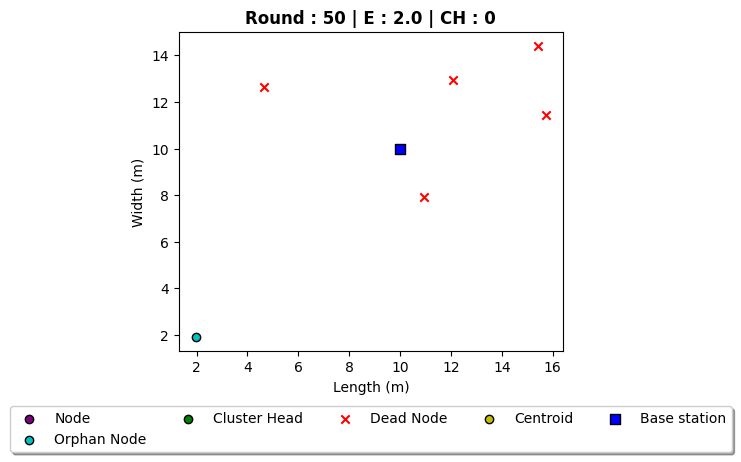

Paths : []


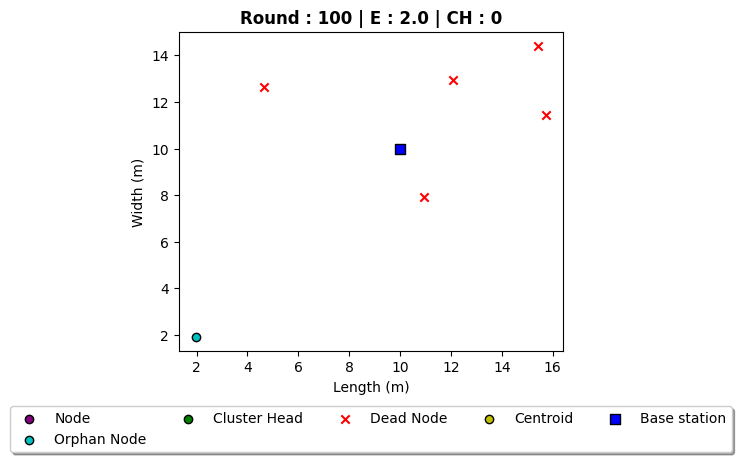

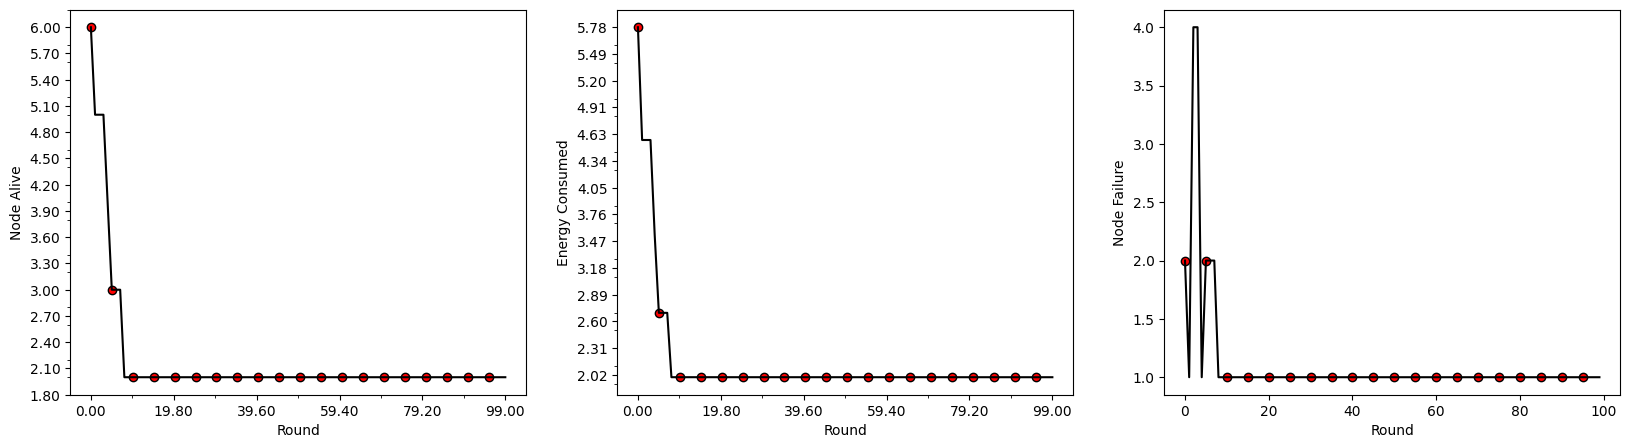

In [49]:
node_LEACH    = createNetworks(N, P, L)
LEACH = networkEnvironment(node_LEACH, "LEACH", False, 50)
LEACH_aliveNode, LEACH_EnergyNode, LEACH_NodeFailure = LEACH.startSimulation(100)

Graph with 16 nodes and 120 edges
Node : 1 => Paths : [1, 13, 7, 6, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 6, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5, 2, 14, 5,

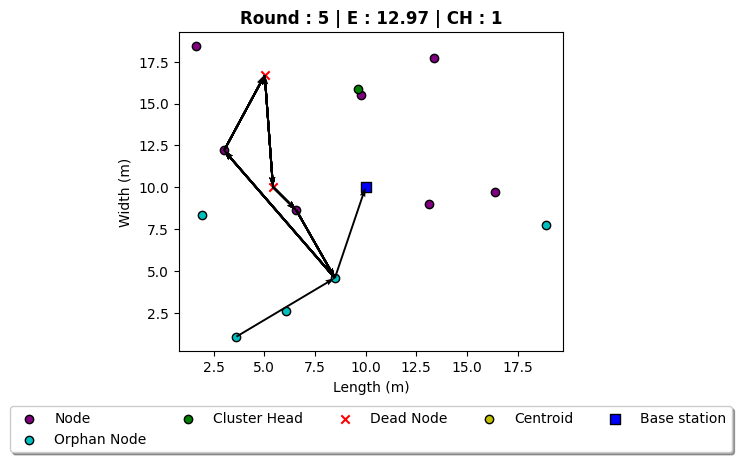

Graph with 16 nodes and 120 edges
Node : 3 => Paths : [3, 15, 5, 14, 6, 2, 4, 1, 12, 5, 14, 6, 2, 4, 1, 12, 5, 14, 6, 2, 4, 1, 12, 5, 14, 6, 2, 4, 1, 12, 5, 14, 6, 2, 4, 1, 12, 5, 14, 6, 2, 4, 1, 12, 5, 14, 6, 2, 4, 1, 12, 5, 14, 6, 2, 4, 1, 12, 5, 14, 6, 2, 4, 1, 12, 5, 14, 6, 2, 4, 1, 12, 5, 14, 6, 2, 4, 10, 5, 14, 6, 2, 4, 1, 12, 5, 14, 6, 2, 4, 1, 12, 5, 14, 6, 2, 4, 1, 12, 5, 14, 6, 2, 4, 1, 12, 5, 14, 6, 2, 4, 14, 6, 2, 4, 1, 12, 5, 14, 6, 2, 4, 1, 12, 5, 14, 6, 2, 4, 1, 12, 5, 14, 6, 2, 4, 1, 12, 5, 14, 6, 2, 4, 1, 12, 5, 14, 6, 2, 4, 1, 12, 5, 14, 6, 2, 4, 1, 12, 5, 14, 6, 2, 4, 1, 12, 5, 14, 6, 2, 4, 1, 12, 5, 14, 6, 2, 4, 1, 12, 5, 14, 6, 2, 4, 1, 12, 5, 14, 6, 2, 4, 1, 12, 5, 14, 6, 2, 4, 1, 12, 5, 14, 6, 2, 4, 1, 12, 5, 14, 6, 2, 4, 1, 12, 5, 14, 6, 2, 4, 1, 12, 5, 14, 6, 2, 4, 1, 4, 1, 12, 5, 14, 6, 2, 4, 1, 12, 5, 14, 6, 2, 4, 1, 12, 5, 14, 6, 2, 4, 1, 12, 5, 14, 6, 2, 4, 1, 12, 5, 14, 6, 2, 4, 1, 12, 5, 14, 0]
Graph with 16 nodes and 120 edges
Node : 8 => Paths : [8, 9, 

: 

In [ ]:
node_Q_Learning    = createNetworks(N, P, L)
Q_Learning = networkEnvironment(node_Q_Learning, "Q-Learning", False, 5)
Q_Learning_aliveNode, Q_Learning_EnergyNode, Q_Learning_NodeFailure = Q_Learning.startSimulation(50)